<a href="https://colab.research.google.com/github/LeonWa24/Dai_AirBnB/blob/main/AirBnB_Berlin_Listings_V1.8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AirBnB pricing model

The objective of this mission is to analyze and develop a model to determine the optimal pricing for Airbnb listings, with a specific focus on properties located in the Berlin area. The project involves several key steps. First, it requires collecting data on various Airbnb listings, including factors such as location, amenities, property type, and customer reviews. Next, the project entails performing exploratory data analysis to identify patterns and correlations that affect pricing. After that, the goal is to develop a predictive model using appropriate statistical and machine learning techniques to estimate the ideal price for an Airbnb listing.

The data is made accessible by the Kaggle user "The Devastator" and is available at the following link: [Berlin Airbnb Ratings: How Hosts Measure Up](https://www.kaggle.com/datasets/thedevastator/berlin-airbnb-ratings-how-hosts-measure-up).

Following packages are needed to execute the code in this Notebook.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, \
     mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR

from scipy import stats

import warnings
warnings.filterwarnings('ignore')


## Import data

This part of the code is for importing the Dataset. The.csv file is accessible via GitHub. If necessary change url.

In [5]:
BerlinWeekDays = pd.read_csv('https://raw.githubusercontent.com/LeonWa24/Dai_AirBnB/main/AirBnB%20Listings/berlin_weekdays.csv')
BerlinWeekEnd = pd.read_csv('https://raw.githubusercontent.com/LeonWa24/Dai_AirBnB/main/AirBnB%20Listings/berlin_weekends.csv')


BerlinWeekDays.drop(columns = ['Unnamed: 0'],inplace=True)
BerlinWeekEnd.drop(columns = ['Unnamed: 0'],inplace=True)

#print(BerlinWeekDays.head())
#print(BerlinWeekEnd.head())

def combine(Dataframe1,Dataframe2):       # Combine the 2 datasets into a single dataset.
    Dataframe1['Weekday_Weekend'] = 'Weekday'
    Dataframe2['Weekday_Weekend'] = 'Weekend'
    combined = pd.concat([Dataframe1, Dataframe2])
    return combined
berlin = combine(BerlinWeekDays,BerlinWeekEnd)
berlin

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,Weekday_Weekend
0,185.799757,Private room,False,True,2.0,True,0,0,10.0,98.0,1,3.582211,0.174706,105.063708,16.019042,148.941114,30.710638,13.42344,52.49150,Weekday
1,194.914462,Private room,False,True,5.0,False,0,1,9.0,86.0,1,3.525410,0.511922,75.339529,11.487002,106.442356,21.947685,13.46800,52.51900,Weekday
2,176.217631,Private room,False,True,2.0,False,0,0,9.0,91.0,1,3.801713,0.281397,73.669176,11.232324,105.440205,21.741048,13.47096,52.51527,Weekday
3,207.768533,Private room,False,True,3.0,True,0,0,10.0,97.0,1,0.982408,0.705573,133.187409,20.307057,198.233362,40.874362,13.42281,52.53139,Weekday
4,150.743199,Private room,False,True,2.0,False,0,0,10.0,99.0,1,8.869697,2.187188,39.860151,6.077469,50.996308,10.515090,13.52440,52.47842,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,84.836870,Private room,False,True,2.0,False,0,0,10.0,100.0,1,16.417127,4.070691,23.484663,3.579546,30.663099,6.487380,13.54900,52.40000,Weekend
1196,134.617182,Private room,False,True,4.0,False,1,0,10.0,98.0,1,14.971985,2.620839,25.750931,3.924972,33.433648,7.073544,13.53187,52.40874,Weekend
1197,134.617182,Private room,False,True,4.0,False,1,0,10.0,93.0,1,15.166175,2.754838,25.439079,3.877440,33.027106,6.987532,13.53301,52.40712,Weekend
1198,160.091614,Entire home/apt,False,False,3.0,False,0,0,9.0,86.0,1,22.617458,13.314115,16.600731,2.530293,21.455797,4.539394,13.70702,52.42405,Weekend


## Understanding the data

Explanation of non-self-explanatory variables:

*   realSum = Price per night
*   room_type = Private room or entire home
*   multi = Host got multiple listings (1) or only one listing (0)
* biz = Listing is suitable for business travel (1) or not (0)
* cleanliness_rating = Average coustomer review on scale 1 to 10
* cleanliness_rating = Average coustomer review on scale 1 to 10
*   attr_index_norm = normalized data (1 to 100) of a listings attracktion, as AirBnB calculates it. (Exact input unknown)
*   rest_index_norm =  normalized data (1 to 100) of a listings resting ability (sleep quality etc.), as AirBnB calculates it. (Exact input unknown)

*   lng = longitude of a listing

*   lat = latitude of a listing
*   host_is_superhost = The Superhost badge is a way for costumers to quickly find good hosts that are getting good reviews and show good behaviour











### Map visualisation

In the following all the listings are displayed on an interaktive Map of Berlin to display the Distribution within the city.

In [6]:
# Create a map centered around Berlin
map_berlin = folium.Map(location=[52.52, 13.4050], zoom_start=12)

# Add markers to the map
for index, row in berlin.iterrows():
    folium.Marker([row['lat'], row['lng']]).add_to(map_berlin)

#Adding a red pin for Berlin City Centre
berlin_city_centre = [52.5200, 13.4050]
folium.Marker(
    location=berlin_city_centre,
    popup="Berlin City Centre",
    icon=folium.Icon(color='red')
).add_to(map_berlin)
# Display the map
map_berlin

### Column inspection

In [7]:
print("Column Inspection\n")
print(berlin.info())

print("\n\nInspection of quantittive variables")
berlin.describe()
#print(berlin.isna().sum())

Column Inspection

<class 'pandas.core.frame.DataFrame'>
Index: 2484 entries, 0 to 1199
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     2484 non-null   float64
 1   room_type                   2484 non-null   object 
 2   room_shared                 2484 non-null   bool   
 3   room_private                2484 non-null   bool   
 4   person_capacity             2484 non-null   float64
 5   host_is_superhost           2484 non-null   bool   
 6   multi                       2484 non-null   int64  
 7   biz                         2484 non-null   int64  
 8   cleanliness_rating          2484 non-null   float64
 9   guest_satisfaction_overall  2484 non-null   float64
 10  bedrooms                    2484 non-null   int64  
 11  dist                        2484 non-null   float64
 12  metro_dist                  2484 non-null   float64
 13  attr_index         

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000
mean,244.583752,2.774960,0.276167,0.174718,9.461755,94.323671,1.070451,5.257093,0.836064,110.223416,16.803111,146.875822,30.666967,13.399729,52.509110
std,235.329289,1.188142,0.447191,0.379802,0.849384,6.809406,0.552033,3.692649,1.267283,70.676310,10.774273,79.639119,16.634505,0.071801,0.033257
min,64.971487,2.000000,0.000000,0.000000,4.000000,20.000000,0.000000,0.180926,0.011376,15.152201,2.309508,19.576924,4.141882,13.116320,52.370000
25%,144.900439,2.000000,0.000000,0.000000,9.000000,92.000000,1.000000,2.836557,0.271908,68.380692,10.422633,92.638581,19.378819,13.358110,52.490850
50%,191.175096,2.000000,0.000000,0.000000,10.000000,96.000000,1.000000,4.282886,0.450483,91.128207,13.892056,131.109337,27.410860,13.407420,52.509740
75%,278.349070,3.000000,1.000000,0.000000,10.000000,99.000000,1.000000,6.665746,0.808505,131.311184,20.019760,185.457015,38.818175,13.440238,52.530100
max,5857.483407,6.000000,1.000000,1.000000,10.000000,100.000000,9.000000,25.284557,14.273577,656.079318,100.000000,484.982156,100.000000,13.711850,52.641410



Distribution of columns with data type object or bool.

In [8]:
# Analyze object type columns
print("Inspection of qualitative variables\n")
for col in berlin.select_dtypes(include=['object']):
    print(berlin[col].value_counts(normalize=True) * 100) # Normalize to get percentages
    print("-" * 30)

# Analyze bool type columns
for col in berlin.select_dtypes(include=['bool']):
    print(berlin[col].value_counts(normalize=True) * 100)
    print("-" * 30)

Inspection of qualitative variables

room_type
Private room       61.553945
Entire home/apt    35.507246
Shared room         2.938808
Name: proportion, dtype: float64
------------------------------
Weekday_Weekend
Weekday    51.690821
Weekend    48.309179
Name: proportion, dtype: float64
------------------------------
room_shared
False    97.061192
True      2.938808
Name: proportion, dtype: float64
------------------------------
room_private
True     61.553945
False    38.446055
Name: proportion, dtype: float64
------------------------------
host_is_superhost
False    74.275362
True     25.724638
Name: proportion, dtype: float64
------------------------------


The Data consist of 20 columns, without missing Data. The column represents things such as ratings or apartment features that are unique to each listing. There are no missing values in this dataset, which simplifies the data cleanup. The listings differentiate between it being a weekday or the weekend. Theoretically it would be possible to find doublicate listing by looking at the longitude and latitude columns.

### Dataframe cleaning

For the data analysis and the visualization of the data it might be helpful to convert categorical variables to boolean variables by using dummy variables.

In [9]:
berlin_dummies = pd.get_dummies(berlin['room_type'])
del berlin_dummies[berlin_dummies.columns[-1]]
berlin_neu = pd.concat([berlin, berlin_dummies], axis=1)
del berlin_neu['room_type']


berlin_dummies2 = pd.get_dummies(berlin_neu['Weekday_Weekend'])
del berlin_dummies2[berlin_dummies2.columns[-1]]
berlin_neu2 = pd.concat([berlin_neu, berlin_dummies2], axis=1)
del berlin_neu2['Weekday_Weekend']

berlin_neu2

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,Entire home/apt,Private room,Weekday
0,185.799757,False,True,2.0,True,0,0,10.0,98.0,1,...,0.174706,105.063708,16.019042,148.941114,30.710638,13.42344,52.49150,False,True,True
1,194.914462,False,True,5.0,False,0,1,9.0,86.0,1,...,0.511922,75.339529,11.487002,106.442356,21.947685,13.46800,52.51900,False,True,True
2,176.217631,False,True,2.0,False,0,0,9.0,91.0,1,...,0.281397,73.669176,11.232324,105.440205,21.741048,13.47096,52.51527,False,True,True
3,207.768533,False,True,3.0,True,0,0,10.0,97.0,1,...,0.705573,133.187409,20.307057,198.233362,40.874362,13.42281,52.53139,False,True,True
4,150.743199,False,True,2.0,False,0,0,10.0,99.0,1,...,2.187188,39.860151,6.077469,50.996308,10.515090,13.52440,52.47842,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,84.836870,False,True,2.0,False,0,0,10.0,100.0,1,...,4.070691,23.484663,3.579546,30.663099,6.487380,13.54900,52.40000,False,True,False
1196,134.617182,False,True,4.0,False,1,0,10.0,98.0,1,...,2.620839,25.750931,3.924972,33.433648,7.073544,13.53187,52.40874,False,True,False
1197,134.617182,False,True,4.0,False,1,0,10.0,93.0,1,...,2.754838,25.439079,3.877440,33.027106,6.987532,13.53301,52.40712,False,True,False
1198,160.091614,False,False,3.0,False,0,0,9.0,86.0,1,...,13.314115,16.600731,2.530293,21.455797,4.539394,13.70702,52.42405,True,False,False


Visualizing the new column

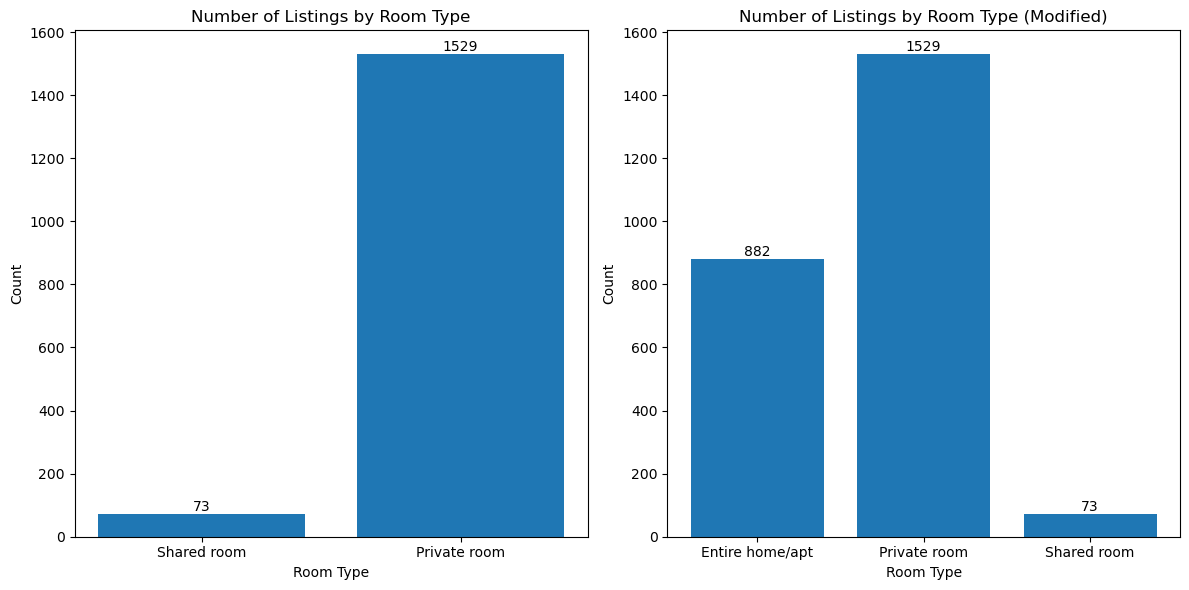

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Number of Listings by Room Type
room_shared_count = berlin_neu2['room_shared'].sum()
room_private_count = berlin_neu2['room_private'].sum()
axes[0].bar(['Shared room', 'Private room'], [room_shared_count, room_private_count])
axes[0].set_xlabel('Room Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Number of Listings by Room Type')

for i, v in enumerate([room_shared_count, room_private_count]):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Plot 2: Number of Listings by Room Type (Modified)
axes[1].bar(['Entire home/apt', 'Private room', 'Shared room'], [berlin_neu2['Entire home/apt'].sum(), berlin_neu2['Private room'].sum(), ((berlin_neu2['Entire home/apt'] == False) & (berlin_neu2['Private room'] == False)).sum()])
axes[1].set_xlabel('Room Type')
axes[1].set_ylabel('Count')
axes[1].set_title('Number of Listings by Room Type (Modified)')

for i, v in enumerate([berlin_neu2['Entire home/apt'].sum(), berlin_neu2['Private room'].sum(), ((berlin_neu2['Entire home/apt'] == False) & (berlin_neu2['Private room'] == False)).sum()]):
    axes[1].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


The 'True' values of columns 'room_private' and 'room_shared' dont add up to the total amount of listings. 1529 + 73 = 1602, the values should add up to 2484 as a room can either be shared or not. These 2 variables might be misleading. If we only look at the columns 'Entire home/apt' and 'Private room', we can see that if both column have the value "False", they correspond to the number of shared rooms, which the way it was intended. This means the columns room_shared	'room_private' can be dropped as they dont give any additional information that are not already in the dataframe through the addition of previously mentioned dummy variable.

In [11]:
berlin_neu3 = berlin_neu2.drop(['room_private', 'room_shared'], axis=1)
berlin_neu3

,realSum,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,Entire home/apt,Private room,Weekday
0,185.799757,2.0,True,0,0,10.0,98.0,1,3.582211,0.174706,105.063708,16.019042,148.941114,30.710638,13.42344,52.49150,False,True,True
1,194.914462,5.0,False,0,1,9.0,86.0,1,3.525410,0.511922,75.339529,11.487002,106.442356,21.947685,13.46800,52.51900,False,True,True
2,176.217631,2.0,False,0,0,9.0,91.0,1,3.801713,0.281397,73.669176,11.232324,105.440205,21.741048,13.47096,52.51527,False,True,True
3,207.768533,3.0,True,0,0,10.0,97.0,1,0.982408,0.705573,133.187409,20.307057,198.233362,40.874362,13.42281,52.53139,False,True,True
4,150.743199,2.0,False,0,0,10.0,99.0,1,8.869697,2.187188,39.860151,6.077469,50.996308,10.515090,13.52440,52.47842,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,84.836870,2.0,False,0,0,10.0,100.0,1,16.417127,4.070691,23.484663,3.579546,30.663099,6.487380,13.54900,52.40000,False,True,False
1196,134.617182,4.0,False,1,0,10.0,98.0,1,14.971985,2.620839,25.750931,3.924972,33.433648,7.073544,13.53187,52.40874,False,True,False
1197,134.617182,4.0,False,1,0,10.0,93.0,1,15.166175,2.754838,25.439079,3.877440,33.027106,6.987532,13.53301,52.40712,False,True,False
1198,160.091614,3.0,False,0,0,9.0,86.0,1,22.617458,13.314115,16.600731,2.530293,21.455797,4.539394,13.70702,52.42405,True,False,False


## Analyze the data


### Visualization of the data

First of all we need to figure out what influences the price most. Therefore lets take a look a the general price distribution.

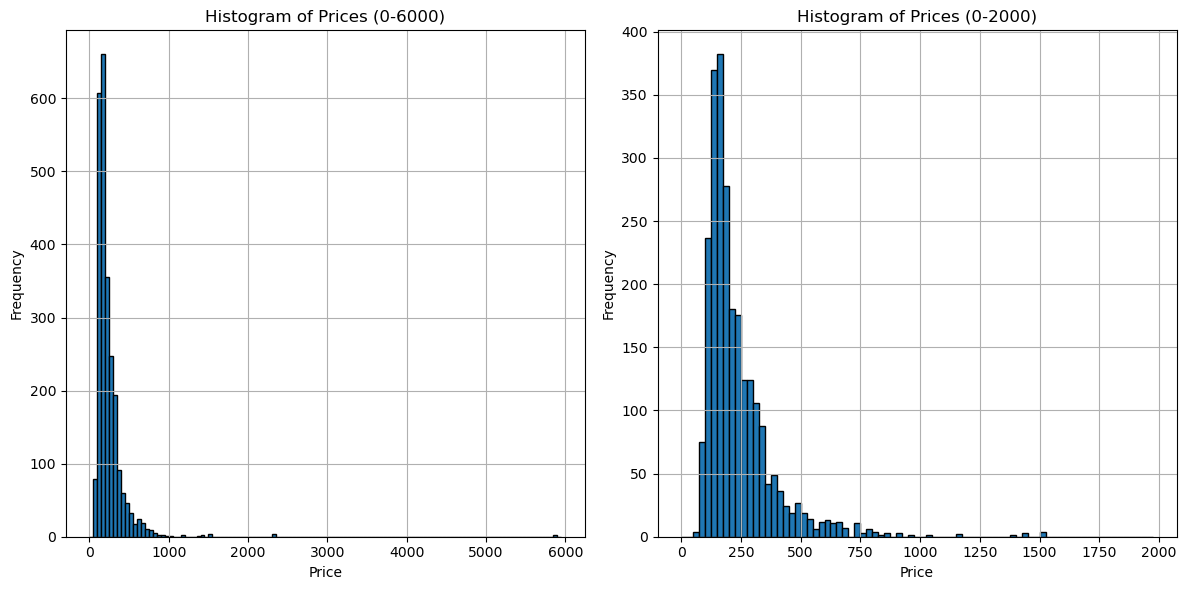

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram 1: Prices with bins from 0 to 6000
axes[0].hist(berlin['realSum'], bins=range(0, 6000, 50), edgecolor='black')
axes[0].set_title('Histogram of Prices (0-6000)')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Histogram 2: Prices with bins from 0 to 2000
axes[1].hist(berlin['realSum'], bins=range(0, 2000,25), edgecolor='black')
axes[1].set_title('Histogram of Prices (0-2000)')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Most Listings seem to be between 150€ and 300€. Unexpectedly there are even a few listings with prices above 2000€ per night.

Lets explore additional variables to get a feel for the data and maybe ge some critical insight that help us in building a model

**Distribution of capacity and bedrooms**

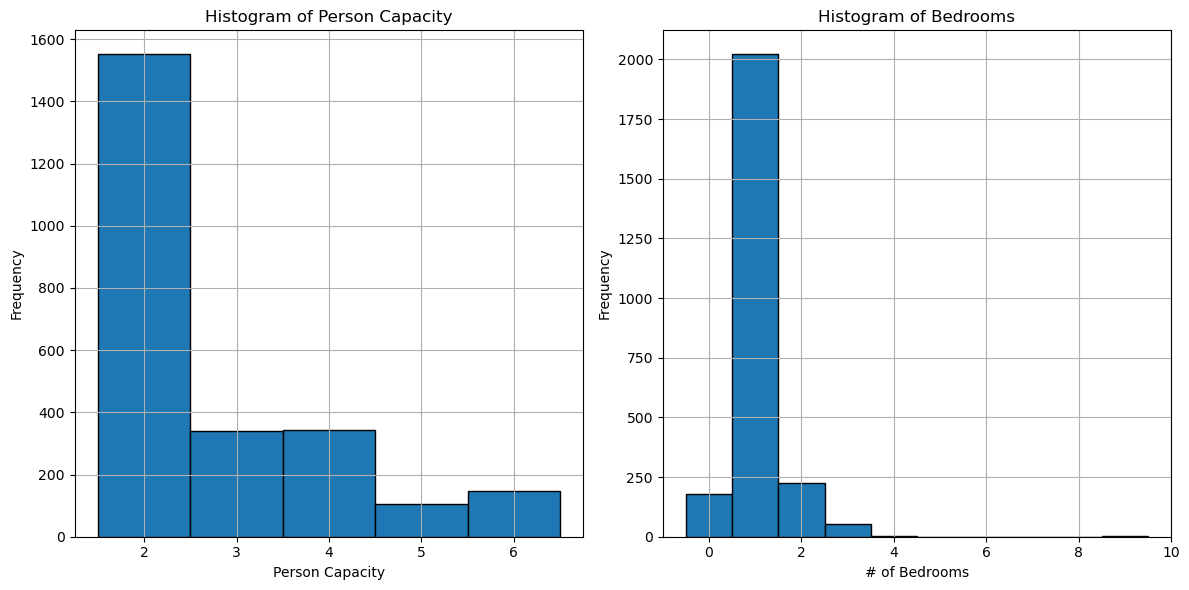

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

bin_edges = [x - 0.5 for x in range(int(min(berlin_neu3['person_capacity'])), int(max(berlin_neu3['person_capacity'])) + 2)]
axes[0].hist(berlin_neu3['person_capacity'], bins=bin_edges, edgecolor='black')
axes[0].set_xlabel('Person Capacity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Person Capacity')
axes[0].grid(True)

bin_edges = [x - 0.5 for x in range(int(min(berlin_neu3['bedrooms'])), int(max(berlin_neu3['bedrooms'])) + 2)]
axes[1].hist(berlin_neu3['bedrooms'], bins=bin_edges, edgecolor='black')
axes[1].set_xlabel('# of Bedrooms')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Bedrooms')
axes[1].grid(True)

plt.tight_layout()
plt.show()

As we can see most listing have a capacity of 2 persons, but there are a good number of listings with a capacity of 3 or 4 persons. Additionally there seems to be only one unusual listing with a number of 9 bedrooms.

**Distribution of Superhost, multi and biz**

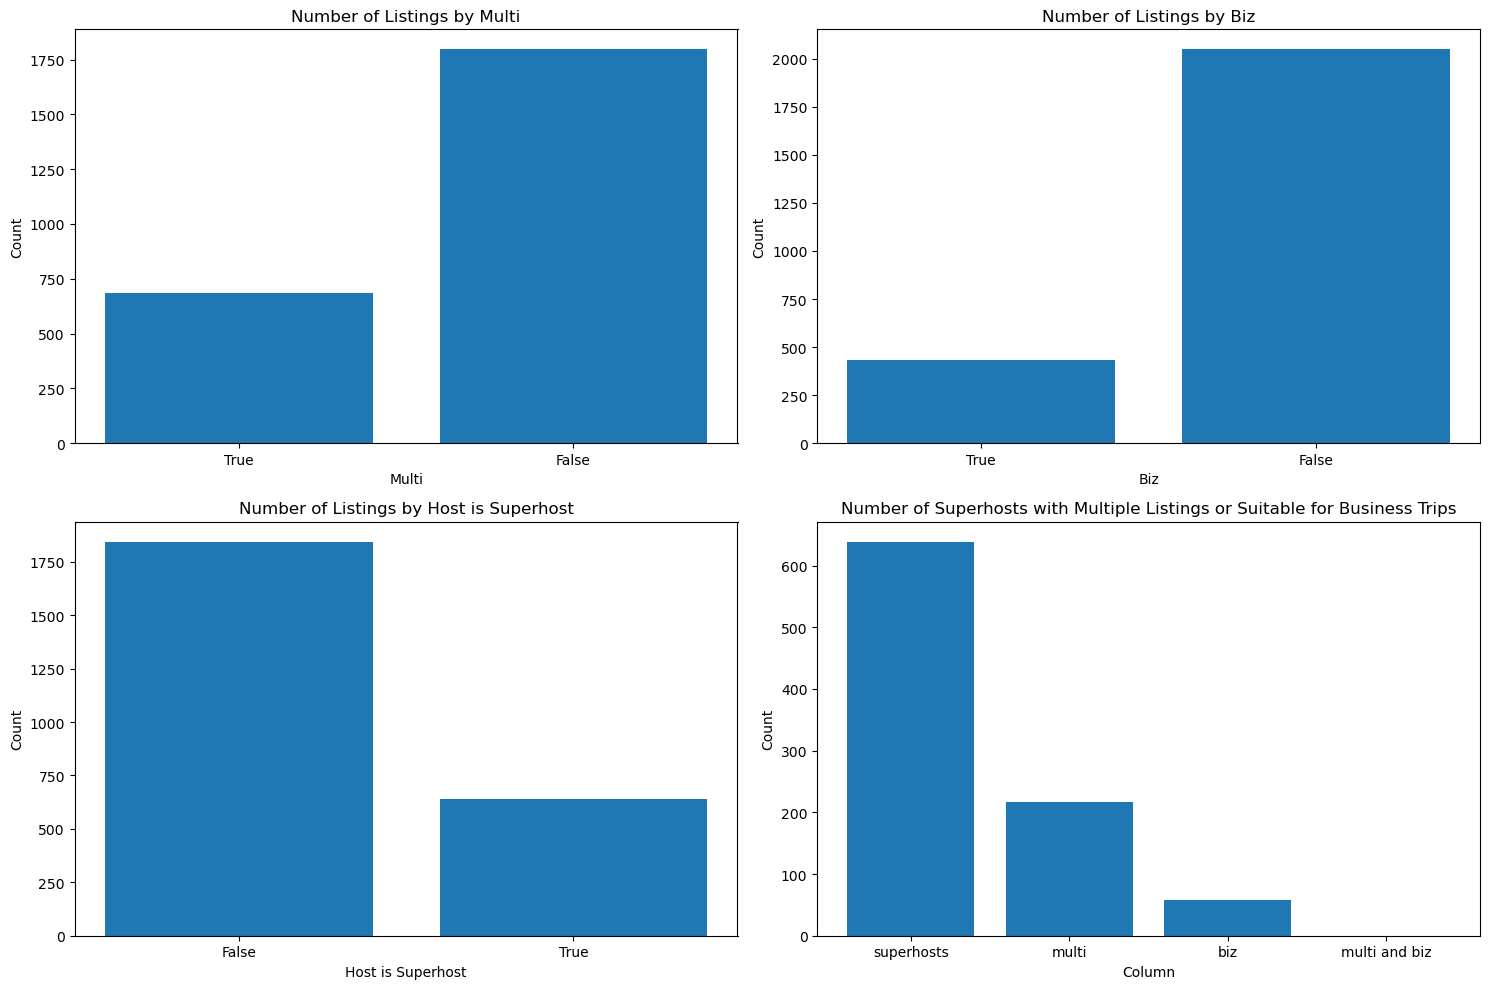

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of Listings by Multi
multi_count = berlin_neu3[berlin_neu3['multi'] == True].shape[0]
non_multi_count = berlin_neu3[berlin_neu3['multi'] == False].shape[0]
axes[0, 0].bar(['True', 'False'], [multi_count, non_multi_count])
axes[0, 0].set_xlabel('Multi')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Number of Listings by Multi')

# Plot 2: Number of Listings by Biz
biz_count = berlin_neu3[berlin_neu3['biz'] == True].shape[0]
non_biz_count = berlin_neu3[berlin_neu2['biz'] == False].shape[0]
axes[0, 1].bar(['True', 'False'], [biz_count, non_biz_count])
axes[0, 1].set_xlabel('Biz')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Number of Listings by Biz')

# Plot 4: Number of Listings by Host is Superhost
host_is_superhost_counts = berlin_neu3['host_is_superhost'].value_counts()
axes[1, 0].bar(host_is_superhost_counts.index.astype(str), host_is_superhost_counts.values)
axes[1, 0].set_xlabel('Host is Superhost')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Number of Listings by Host is Superhost')

# Plot 3: Number of Superhosts with Multiple Listings or Suitable for Business Trips
superhosts = berlin_neu3[berlin_neu3['host_is_superhost'] == True]
multi_count = superhosts[superhosts['multi'] == True].shape[0]
biz_count = superhosts[superhosts['biz'] == True].shape[0]
superhosts_multi_biz_count = superhosts[(superhosts['multi'] == True) & (superhosts['biz'] == True)].shape[0]
total_superhosts = berlin_neu3[berlin_neu3['host_is_superhost'] == True].shape[0]
axes[1, 1].bar(['superhosts', 'multi', 'biz', 'multi and biz'], [total_superhosts, multi_count, biz_count, superhosts_multi_biz_count])
axes[1, 1].set_xlabel('Column')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Number of Superhosts with Multiple Listings or Suitable for Business Trips')

plt.tight_layout()
plt.show()




Around 25% of Listings are listed by a Superhost, 25% of the listings are owned by hosts that have additional listings and only around 18% of the listings are suitable for business use.
Additionally around a third of listings that are owned by hosts of multiple listings are also owned by  a superhost.

**Visualization of distance distribution**

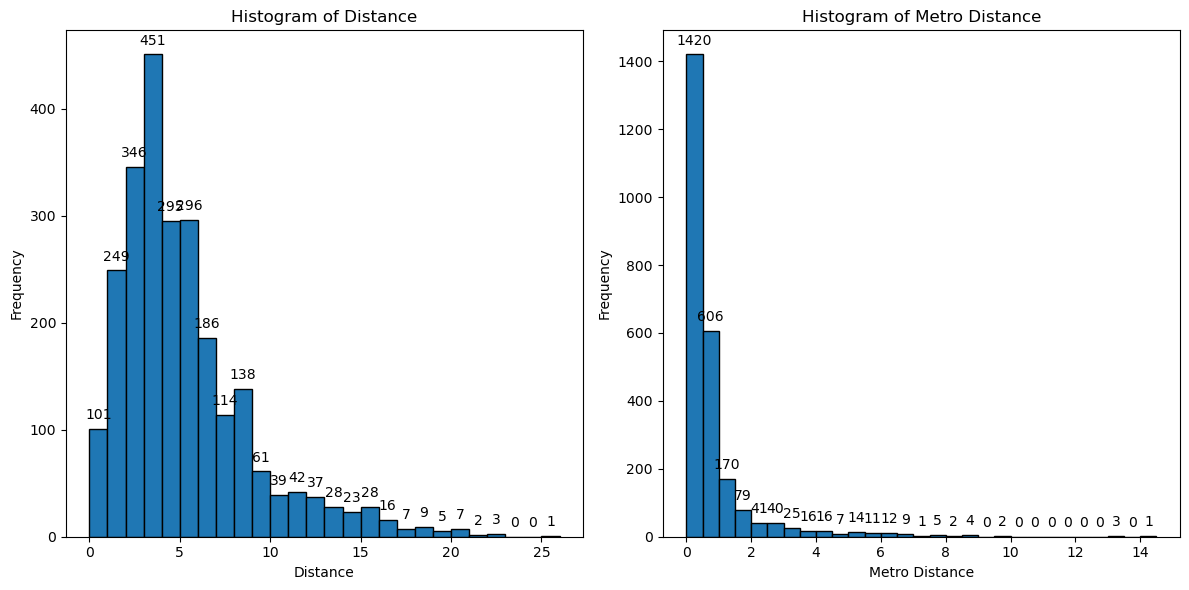

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Histogram of 'dist' with counts
n, bins, patches = axes[0].hist(berlin_neu3['dist'], bins=range(int(min(berlin_neu3['dist'])), int(max(berlin_neu3['dist'])) + 2), edgecolor='black', density=False)
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Distance')

# Add counts to the bins
for count, patch in zip(n, patches):
    axes[0].annotate(str(int(count)), xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), xytext=(0, 5),
                     textcoords='offset points', ha='center', va='bottom')

# Plot 2: Histogram of 'metro_dist' with counts (modified bin size)
n, bins, patches = axes[1].hist(berlin_neu3['metro_dist'], bins=[x / 2 for x in range(int(min(berlin_neu3['metro_dist'] * 2)), int(max(berlin_neu3['metro_dist'] * 2)) + 2)], edgecolor='black', density=False)
axes[1].set_xlabel('Metro Distance')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Metro Distance')

# Add counts to the bins
for count, patch in zip(n, patches):
    axes[1].annotate(str(int(count)), xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), xytext=(0, 5),
                     textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Only  14% of the listings are located within a one kilometer of the city centre, which could be considered an acceptable walking distance. When we look at the distance to the next metro station around 82% of the listings are within a walkable distance. Additionally we see a few listing which are far out of Town.

### Weekend influence

count    1050.000000
mean       12.010711
std        47.828967
min      -280.686174
25%         0.000000
50%         0.000000
75%         9.348415
max       628.213518
Name: realSum_difference, dtype: float64
Negative count: 127
Zero count: 541
Positive count: 382
Mean of positive differences: 39.99690180786608


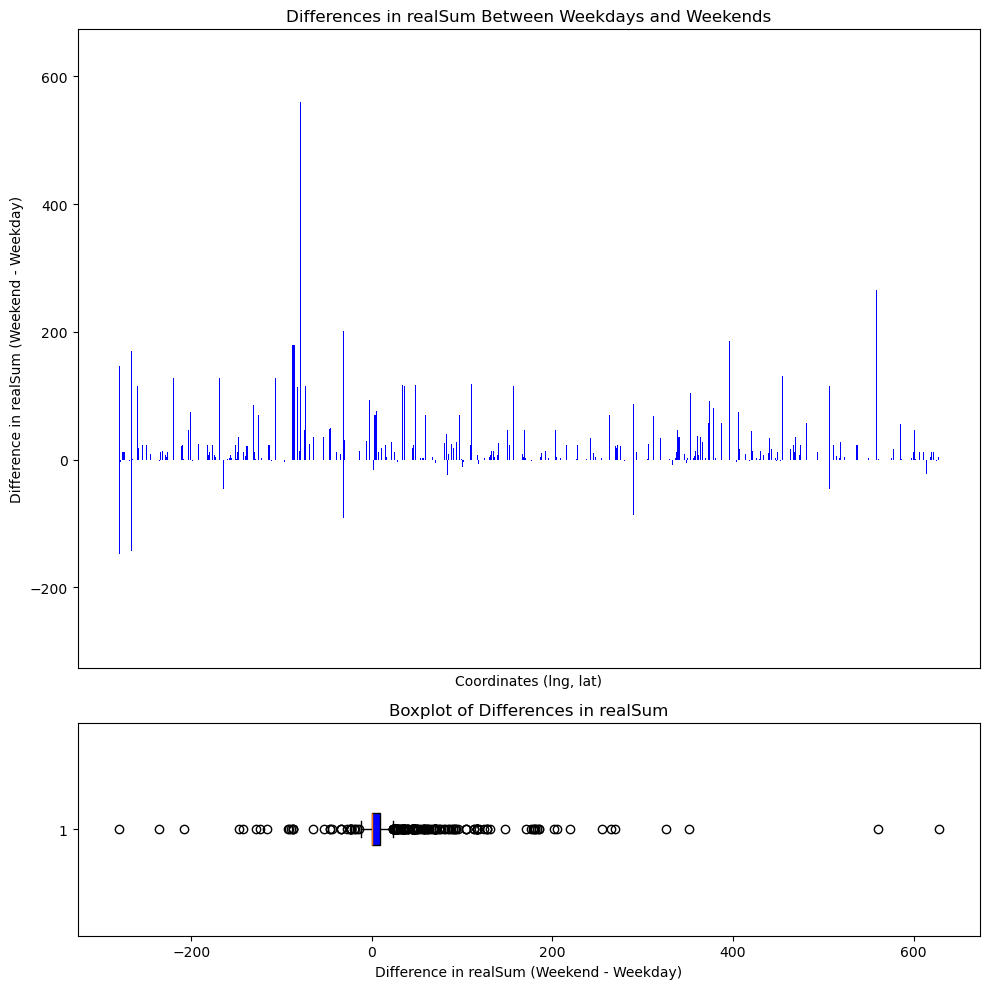

In [16]:
weekdays = berlin_neu2[berlin_neu2['Weekday'] == True]
weekends = berlin_neu2[berlin_neu2['Weekday'] == False]

# 2. Merge the DataFrames based on 'lng' and 'lat' to find pairs
merged_df = pd.merge(weekdays, weekends, on=['lng', 'lat','biz'], suffixes=('_weekday', '_weekend'))

# 3. Calculate the differences in 'realSum'
merged_df['realSum_difference'] = merged_df['realSum_weekend'] - merged_df['realSum_weekday']

# 4. Display the resulting DataFrame
result = merged_df[['lng', 'lat', 'realSum_weekday', 'realSum_weekend', 'realSum_difference']]
neg_count = (merged_df['realSum_difference'] < 0).sum()
zero_count = (merged_df['realSum_difference'] == 0).sum()
pos_count = (merged_df['realSum_difference'] > 0).sum()
print(result['realSum_difference'].describe())
print(f"Negative count: {neg_count}")
print(f"Zero count: {zero_count}")
print(f"Positive count: {pos_count}")

positive_diffs = merged_df[merged_df['realSum_difference'] > 0]['realSum_difference']
mean_positive_diff = positive_diffs.mean()
print(f"Mean of positive differences: {mean_positive_diff}")



coords = merged_df[['lng', 'lat']].astype(str).agg(','.join, axis=1)
realSum_differences = merged_df['realSum_difference']

fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

# Bar plot
ax[0].bar(coords, realSum_differences, color='blue')
ax[0].set_xlabel('Coordinates (lng, lat)')
ax[0].set_ylabel('Difference in realSum (Weekend - Weekday)')
ax[0].set_title('Differences in realSum Between Weekdays and Weekends')
ax[0].set_xticks([])

# Boxplot
ax[1].boxplot(realSum_differences, vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
ax[1].set_title('Boxplot of Differences in realSum')
ax[1].set_xlabel('Difference in realSum (Weekend - Weekday)')

# Display the plots
plt.tight_layout()
plt.show()

The Data reveals that 51% of the prices doesent change for weekends. Around 36% of the listings increase their price for weekends. If there is a increased price for the weekend, the price typically raises arround 40€. In arround 127 cases the price lowered on the weekend.

### Outlier removal

We see a few listings that have price of over 2000, it might be good to remove these outliers to be able to get better information from the data. Additionally we should look at the listings with an unusual amount of bedrooms.

In [17]:
def remove_outliers(df: pd.DataFrame, target_column: str) -> pd.DataFrame:
    """
    Removes outliers from the specified column in the DataFrame based on the IQR method.
    
    This function calculates the Interquartile Range (IQR) for the specified target column and removes 
    rows from the DataFrame where the values in the target column are considered outliers. 
    Outliers are defined as values that lie below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing the data.
        
    target_column : str
        The name of the column from which outliers need to be removed. This column should contain numeric data.
    
    Returns:
    --------
    pd.DataFrame
        The DataFrame with outliers removed from the specified column.
    
    Raises:
    -------
    TypeError
        If the target column contains non-numeric data.
    """

    try:
        quantile_75 = df[target_column].quantile(0.75)
        quantile_25 = df[target_column].quantile(0.25)
        iqr_range = quantile_75 - quantile_25
        high_outliers = quantile_75 + 1.5 * iqr_range
        low_outliers = quantile_25 - 1.5 * iqr_range
        df = df[(df[target_column] < high_outliers) & (df[target_column] > low_outliers)]
    except TypeError:
        print(f'This function only works on numeric columns')
    finally:
        return df

In [18]:
filtered_rows = berlin_neu3[(berlin_neu3['bedrooms'] > 5)]
filtered_rows

,realSum,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,Entire home/apt,Private room,Weekday
263,220.388894,2.0,False,0,0,10.0,95.0,9,3.299137,0.181815,114.836569,17.509108,162.602309,33.527483,13.41991,52.49384,False,True,True
242,220.388894,2.0,False,0,0,10.0,95.0,9,3.299133,0.181802,114.836424,17.503436,162.602490,34.401744,13.41991,52.49384,False,True,False


After looking at the potential outlier and errors we can see that the listings with 9 bedrooms is an error, meaning it can be dropped. Furthermore the listings with a price over 2000 have been removed for beeing to far removed from the other data.

In [19]:
berlin_cleaned = remove_outliers(berlin_neu3, 'realSum')
berlin_cleaned = berlin_cleaned[(berlin_cleaned['bedrooms'] <= 5)]
berlin_cleaned.head()
print(berlin_cleaned.shape)

(2317, 19)


### Correlations

Let us explore the dependencies of our dependend variable price ('realSum') and the other independent variables through a few scatterplots and a correlation heatmap.

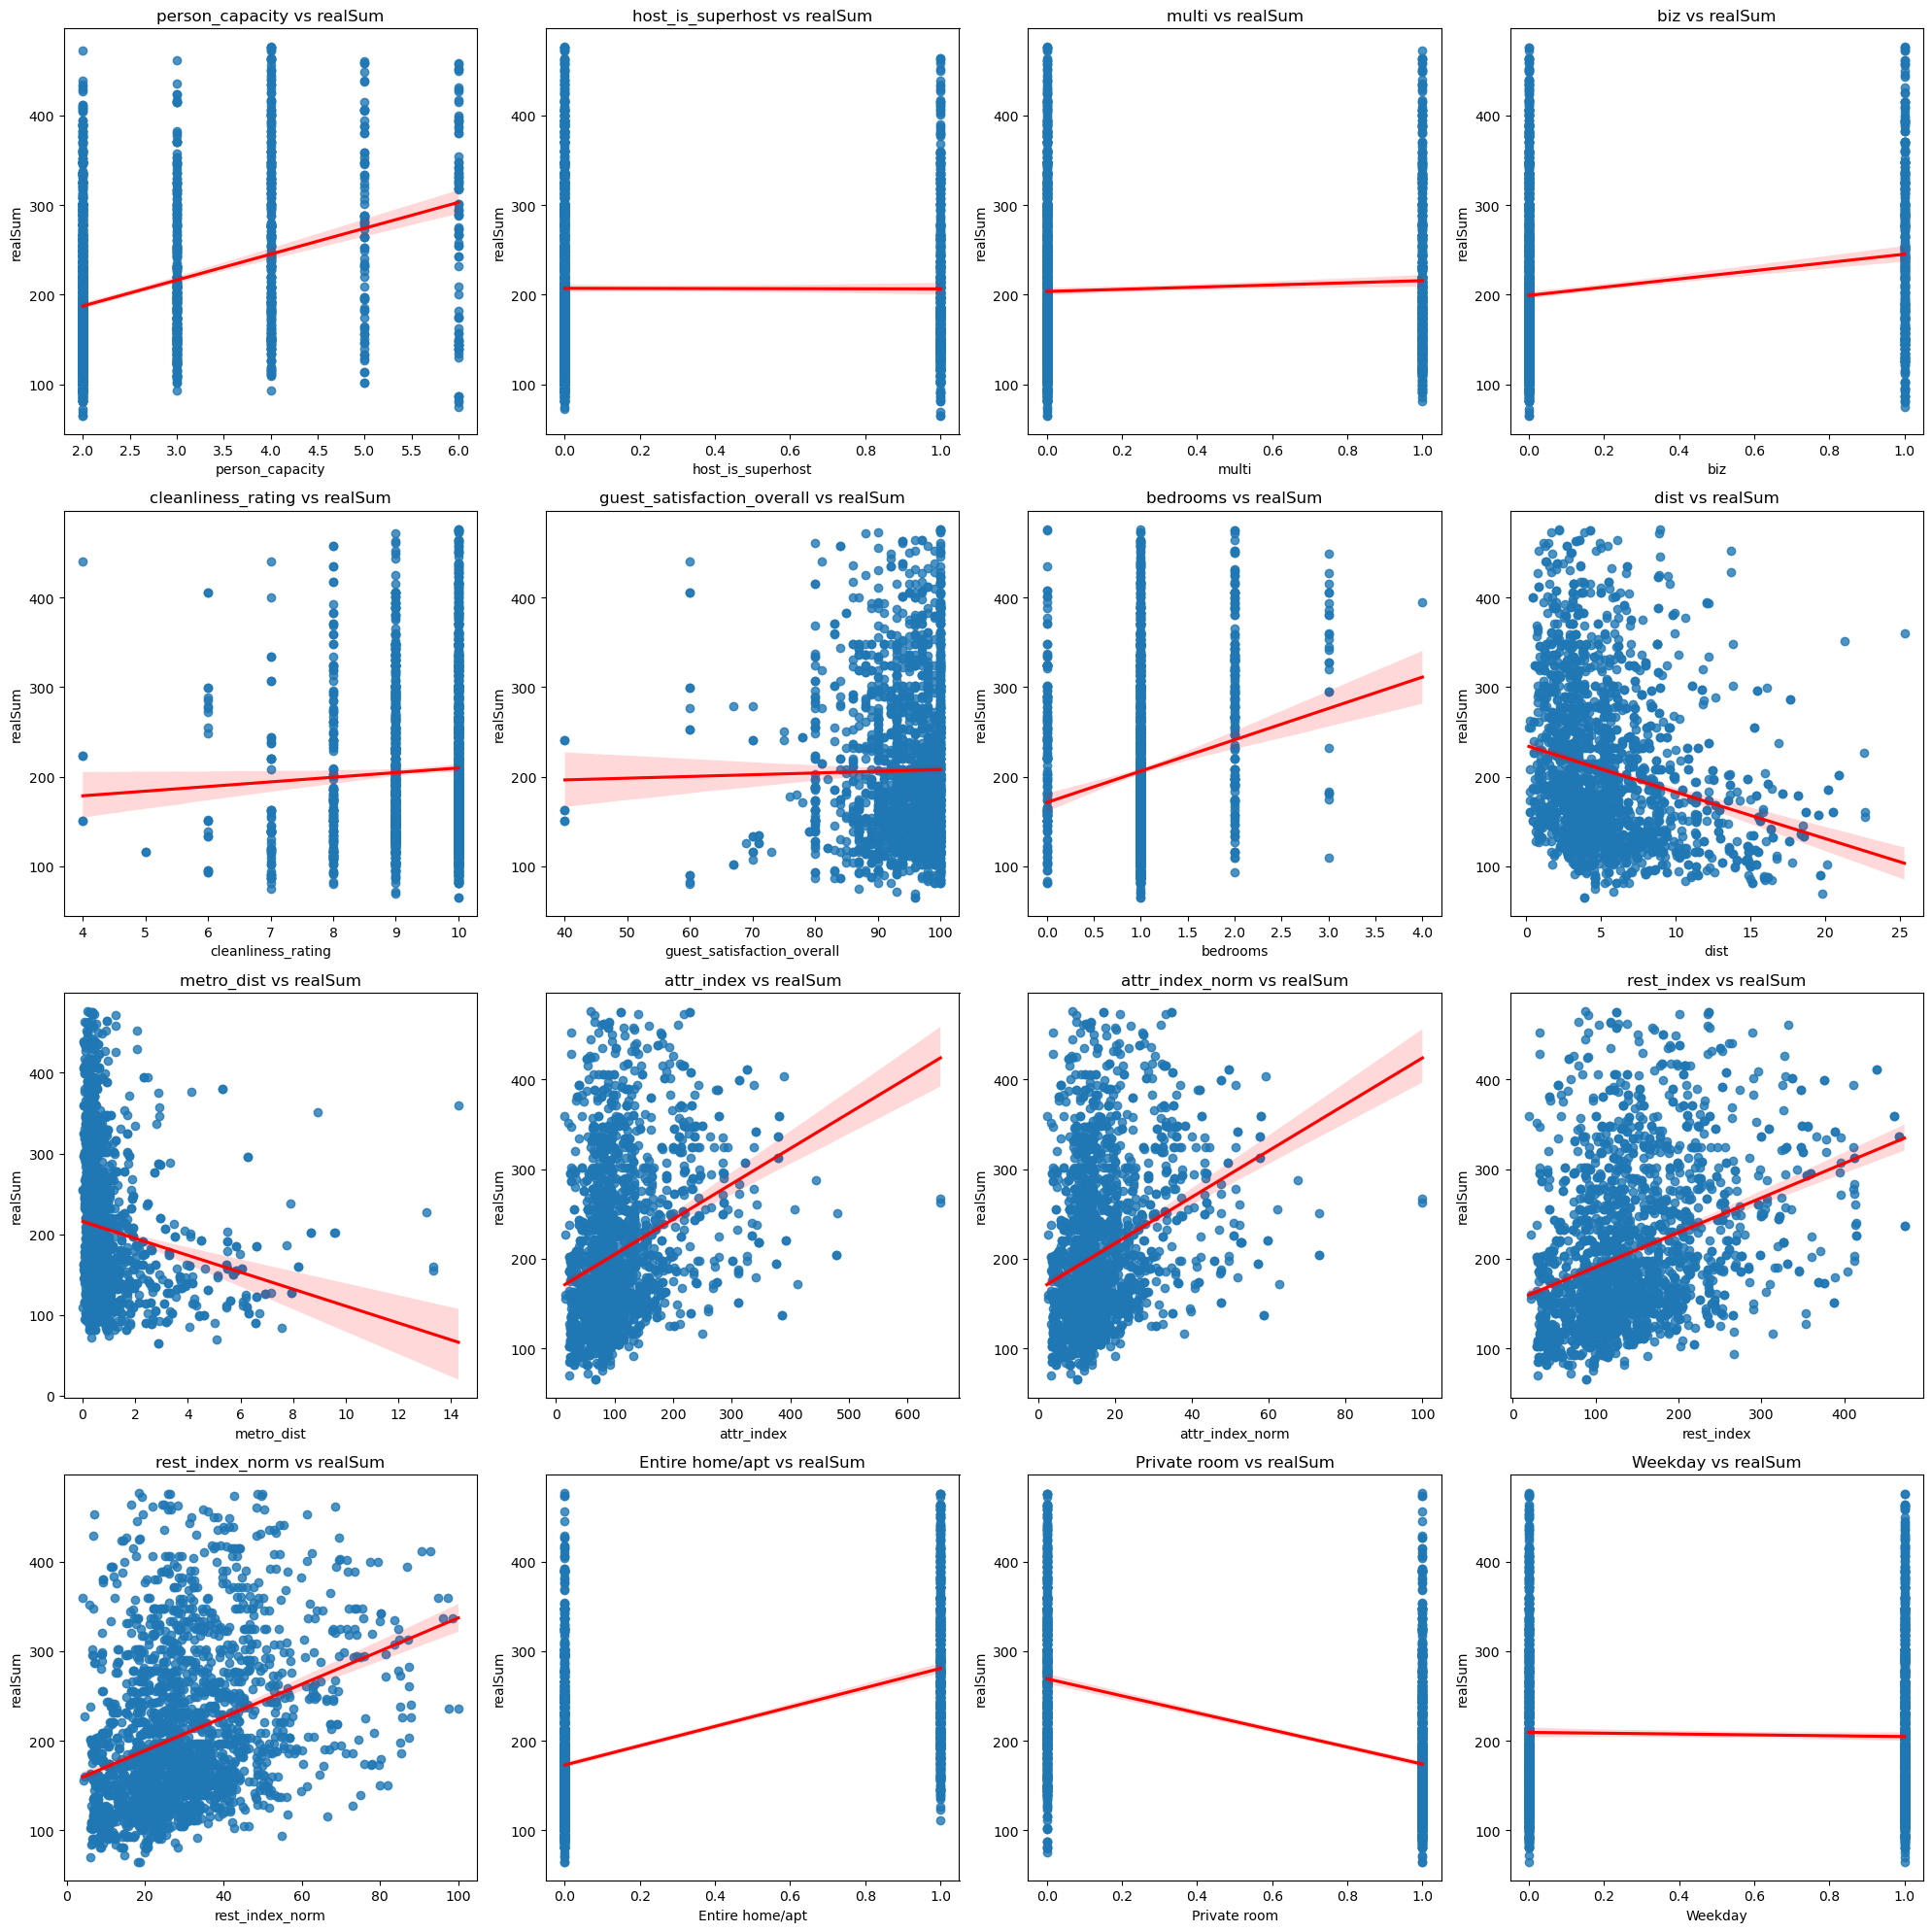

In [38]:
#Get the list of columns in berlin_neu3
columns = berlin_cleaned.columns

#Filter out the columns 'realSum', 'lat', and 'lng'
filtered_columns = [col for col in columns if col not in ['realSum', 'lat', 'lng']]

#Determine the number of rows and columns for the subplot grid
num_plots = len(filtered_columns)
cols_per_row = 4  # Set to 4 per row
num_rows = (num_plots + cols_per_row - 1) // cols_per_row

#Create the subplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(20, num_rows * 5))
axes = axes.flatten()

#Create scatterplots with regression lines
for i, col in enumerate(filtered_columns):
    sns.regplot(x=col, y='realSum', data=berlin_cleaned, ax=axes[i], line_kws={'color': 'red'})
    axes[i].set_title(f'{col} vs realSum')

#Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Correlation matrix**

To get a better overview of the correlations between variables we compute the pearson correlation coefficient using and display it in a seaborn heatmap.

Additionally we use the Point Biserial correlation coefficient as it is the more suitable for continous and binary variables.


In [21]:
# Select the continuous and binary variables
continuous_vars = ['realSum', 'person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat']
binary_vars = ['host_is_superhost', 'multi', 'biz', 'Entire home/apt', 'Private room', 'Weekday']

# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(index=continuous_vars + binary_vars, columns=continuous_vars + binary_vars)

for var1 in correlation_matrix.columns:
    for var2 in correlation_matrix.index:
        if var1 == var2:
            correlation_matrix.loc[var2, var1] = 1.0
        elif var1 in continuous_vars and var2 in continuous_vars:
            correlation_matrix.loc[var2, var1] = berlin_cleaned[var1].corr(berlin_cleaned[var2], method='pearson')
        elif var1 in binary_vars and var2 in binary_vars:
            correlation_matrix.loc[var2, var1] = berlin_cleaned[var1].corr(berlin_cleaned[var2], method='pearson')
        else:
            correlation_matrix.loc[var2, var1] = stats.pointbiserialr(berlin_cleaned[var1], berlin_cleaned[var2])[0]

correlation_matrix = correlation_matrix.astype(float)

correlation_matrix

,realSum,person_capacity,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,host_is_superhost,multi,biz,Entire home/apt,Private room,Weekday
realSum,1.000000,0.365849,0.051497,0.014969,0.177851,-0.224174,-0.157529,0.304831,0.304825,0.341084,0.341614,-0.024626,0.066952,-0.003146,0.062892,0.200797,0.584303,-0.528920,-0.027219
person_capacity,0.365849,1.000000,-0.136436,-0.164777,0.320603,-0.027780,0.026608,-0.018617,-0.018613,-0.009433,-0.009985,0.072595,0.061825,-0.099966,0.004389,0.335924,0.313180,-0.401504,0.025516
cleanliness_rating,0.051497,-0.136436,1.000000,0.608961,0.028644,0.067841,0.002950,-0.006233,-0.006229,0.000155,-0.000195,-0.048463,-0.049034,0.250432,0.003353,-0.098863,-0.009203,0.047432,0.014436
guest_satisfaction_overall,0.014969,-0.164777,0.608961,1.000000,0.055725,0.068365,0.011994,-0.046584,-0.046584,-0.026789,-0.026715,-0.023443,-0.042792,0.263438,0.006455,-0.253023,-0.040117,0.080083,0.000534
bedrooms,0.177851,0.320603,0.028644,0.055725,1.000000,0.033056,0.020203,-0.080533,-0.080528,-0.074800,-0.075266,0.044125,0.018613,0.015547,0.024347,-0.057997,0.053707,-0.049346,0.025009
dist,-0.224174,-0.027780,0.067841,0.068365,0.033056,1.000000,0.630297,-0.595331,-0.595336,-0.635354,-0.634926,-0.272947,-0.403631,0.052605,-0.006443,-0.144943,-0.003791,0.037678,-0.001819
metro_dist,-0.157529,0.026608,0.002950,0.011994,0.020203,0.630297,1.000000,-0.373889,-0.373891,-0.435474,-0.435246,0.127708,-0.111014,0.014888,0.008206,-0.121869,0.041048,-0.030794,0.001966
attr_index,0.304831,-0.018617,-0.006233,-0.046584,-0.080533,-0.595331,-0.373889,1.000000,1.000000,0.868412,0.868297,-0.063527,0.183671,-0.008079,0.016617,0.195272,0.095958,-0.103455,-0.008775
attr_index_norm,0.304825,-0.018613,-0.006229,-0.046584,-0.080528,-0.595336,-0.373891,1.000000,1.000000,0.868415,0.868293,-0.063526,0.183672,-0.008073,0.016619,0.195278,0.095970,-0.103465,-0.008518
rest_index,0.341084,-0.009433,0.000155,-0.026789,-0.074800,-0.635354,-0.435474,0.868412,0.868415,1.000000,0.999626,-0.111971,0.203148,-0.012840,0.047195,0.186982,0.101229,-0.104155,-0.003880


<Axes: >

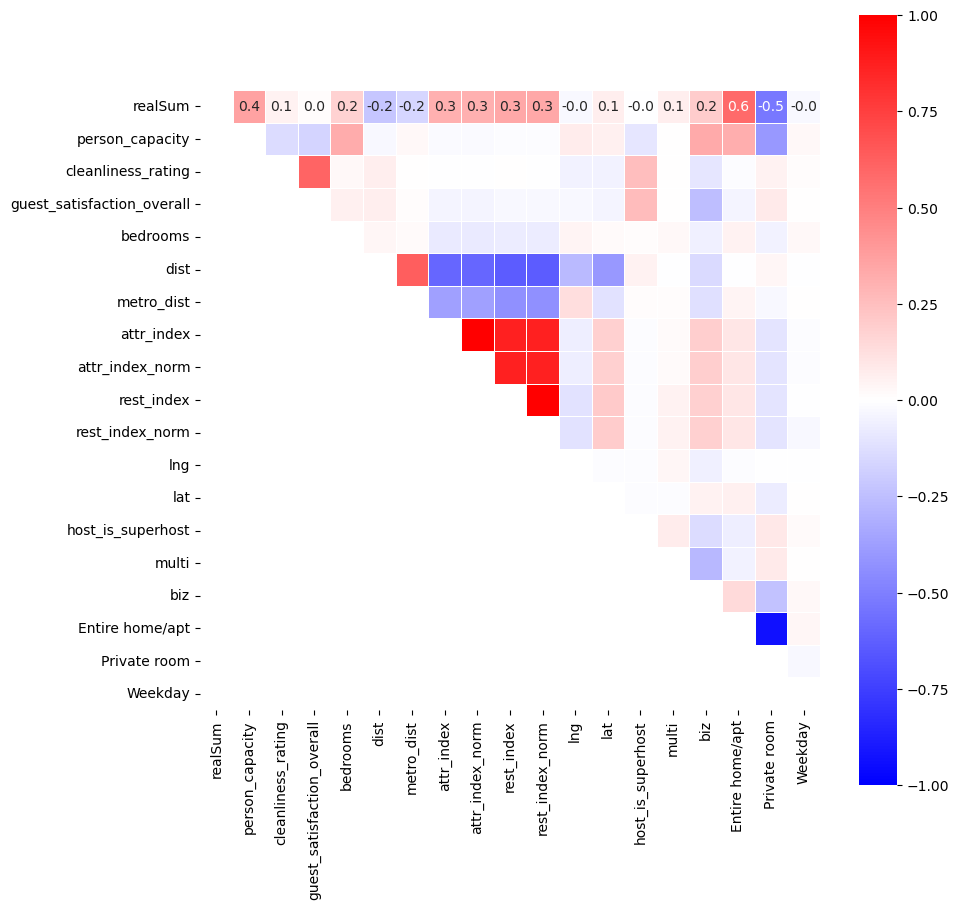

In [22]:
plt.figure(figsize= (10,10))
matrix2 = np.tril(correlation_matrix)
sns.heatmap(correlation_matrix, annot = True,fmt=".1f", mask=matrix2,cmap='bwr', vmin=-1, vmax=1, square=True, linewidths=0.5)


After testing if specifing the different types of correlation coefficients depending on the combination of data types changes the coefficients, we found out that the .corr method already automatically chooses the correct correlation coefficient, meaning, that the above seen heatmap accuratly displays the correlation coefficients of the data.

In the heatmap we can see that the room type has the most correlation with the price, but there are a few weaker correlations that could also be relevant. Additionally we can see that the coefficient matches the findings of the scatterplots.

# Modell building

The models main goal is to select a reasonable price for a AirBnB listing. Therfore the output of the model should be the price per night or realSum as named in the dataset. Because of the price variation between weekdays and weekends the ouput should give a seperate price suggestion for each case.   

When creating a model or a tool for customers to calculate the ideal price for their AirBnB listing, we need to preselect some variables as the models input. For the input it is important, that the customer has the necessary data available. Therefore the following variables from the dataset can NOT be used as a input.

*   cleanliness_rating
*   guest_satisfaction_overall
*   attr_index and normed
*   rest_index and normed

Ecspacially for first time listings, those variables are not available. On the othe hand, if a customer just wants to reconfigurate a listings price, those factors could be counted in.








## Functions for model evaluation

we used the metrics Mean Absolute Error, Mean Squared Error, Root Squared Mean Error, and R² to evaluate the models

In [23]:
def evaluate_model(y_test: pd.Series, y_pred: pd.Series) -> dict:
    """
    Evaluate the performance of a model using various metrics.
    
    Parameters:
    -----------
    y_test: pd.Series
        The true target values from the test set.
    
    y_pred: pd.Series
        The predicted target values from the model.
    
    Returns:
    --------
    dict
        A dictionary containing the evaluation metrics.
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    return {'MAE': mae,'RMSE': rmse, 'MSE': mse, 'R2': r2}

def plot_metrics(title: str, metrics_dict: dict) -> None:
    """
    Plot the evaluation metrics from the model.
    
    Parameters:
    -----------
    title: str
        The title of the plot.
    
    metrics_dict: dict
        A dictionary containing the evaluation metrics.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(metrics_dict.keys(), metrics_dict.values(), color='skyblue')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title(title)
    plt.show()


def plot_compare_metrics(model_names: list[str], metrics_dict_list: list[dict], metric_names: list[str]) -> None:
    """
    Plot the evaluation metrics from multiple models for comparison.
    
    Parameters:
    -----------
    model_names: list[str]
        A list of model names.
    
    metrics_dict_list: list[dict]
        A list of dictionaries containing the evaluation metrics for each model.
    
    metric_names: list[str]
        A list of metric names to plot.
    """
    fig, ax = plt.subplots(2, 2, figsize=(15, 6))
    x = [0, 0, 1, 1]
    y = [0, 1, 0, 1]

    for i, metric in enumerate(metric_names):
        ax[x[i], y[i]].bar(model_names, [metrics[metric] for metrics in metrics_dict_list], color='skyblue')
        ax[x[i], y[i]].set_xlabel('Model')
        ax[x[i], y[i]].set_ylabel(metric)
        ax[x[i], y[i]].set_title(f'{metric} by Model')

    plt.tight_layout()
    plt.show()
   

## Decision Tree Classifier

We start with a basic implementation of a Decision Tree Model and calculated the best max depth for this tree and furthermore we add a tree plot.

24
22


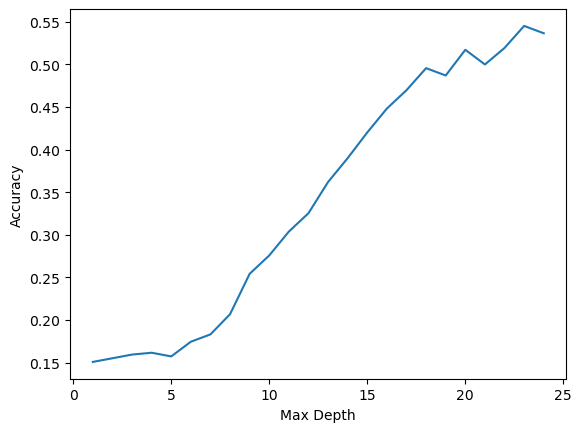

<Figure size 640x480 with 0 Axes>

In [24]:
columns_of_interest = ['multi', 'biz', 'host_is_superhost', 'person_capacity', 'bedrooms', 'dist', 'metro_dist', 'lng', 'lat', 'Entire home/apt', 'Private room', 'Weekday']
df = berlin_cleaned.copy()
df['target_quantiles'] = pd.qcut(df['realSum'], q=12, labels=False)

x_train, x_test, y_train, y_test = train_test_split(df[columns_of_interest], df['realSum']//20 * 20, random_state=1, test_size=0.2)


scores = []
for i in range(1, 25):
    classifier = DecisionTreeClassifier(random_state=1, max_depth=i)
    classifier.fit(x_train, y_train)
    score = classifier.score(x_test, y_test)
    scores.append(score)

print(classifier.tree_.max_depth)
print(scores.index(max(scores)))
plt.plot(range(1, 25), scores)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()
plt.clf()

MAE: 33.44827586206897
MSE: 3808.6206896551726
RMSE: 61.7140234440696
R2: 0.5127087349123366


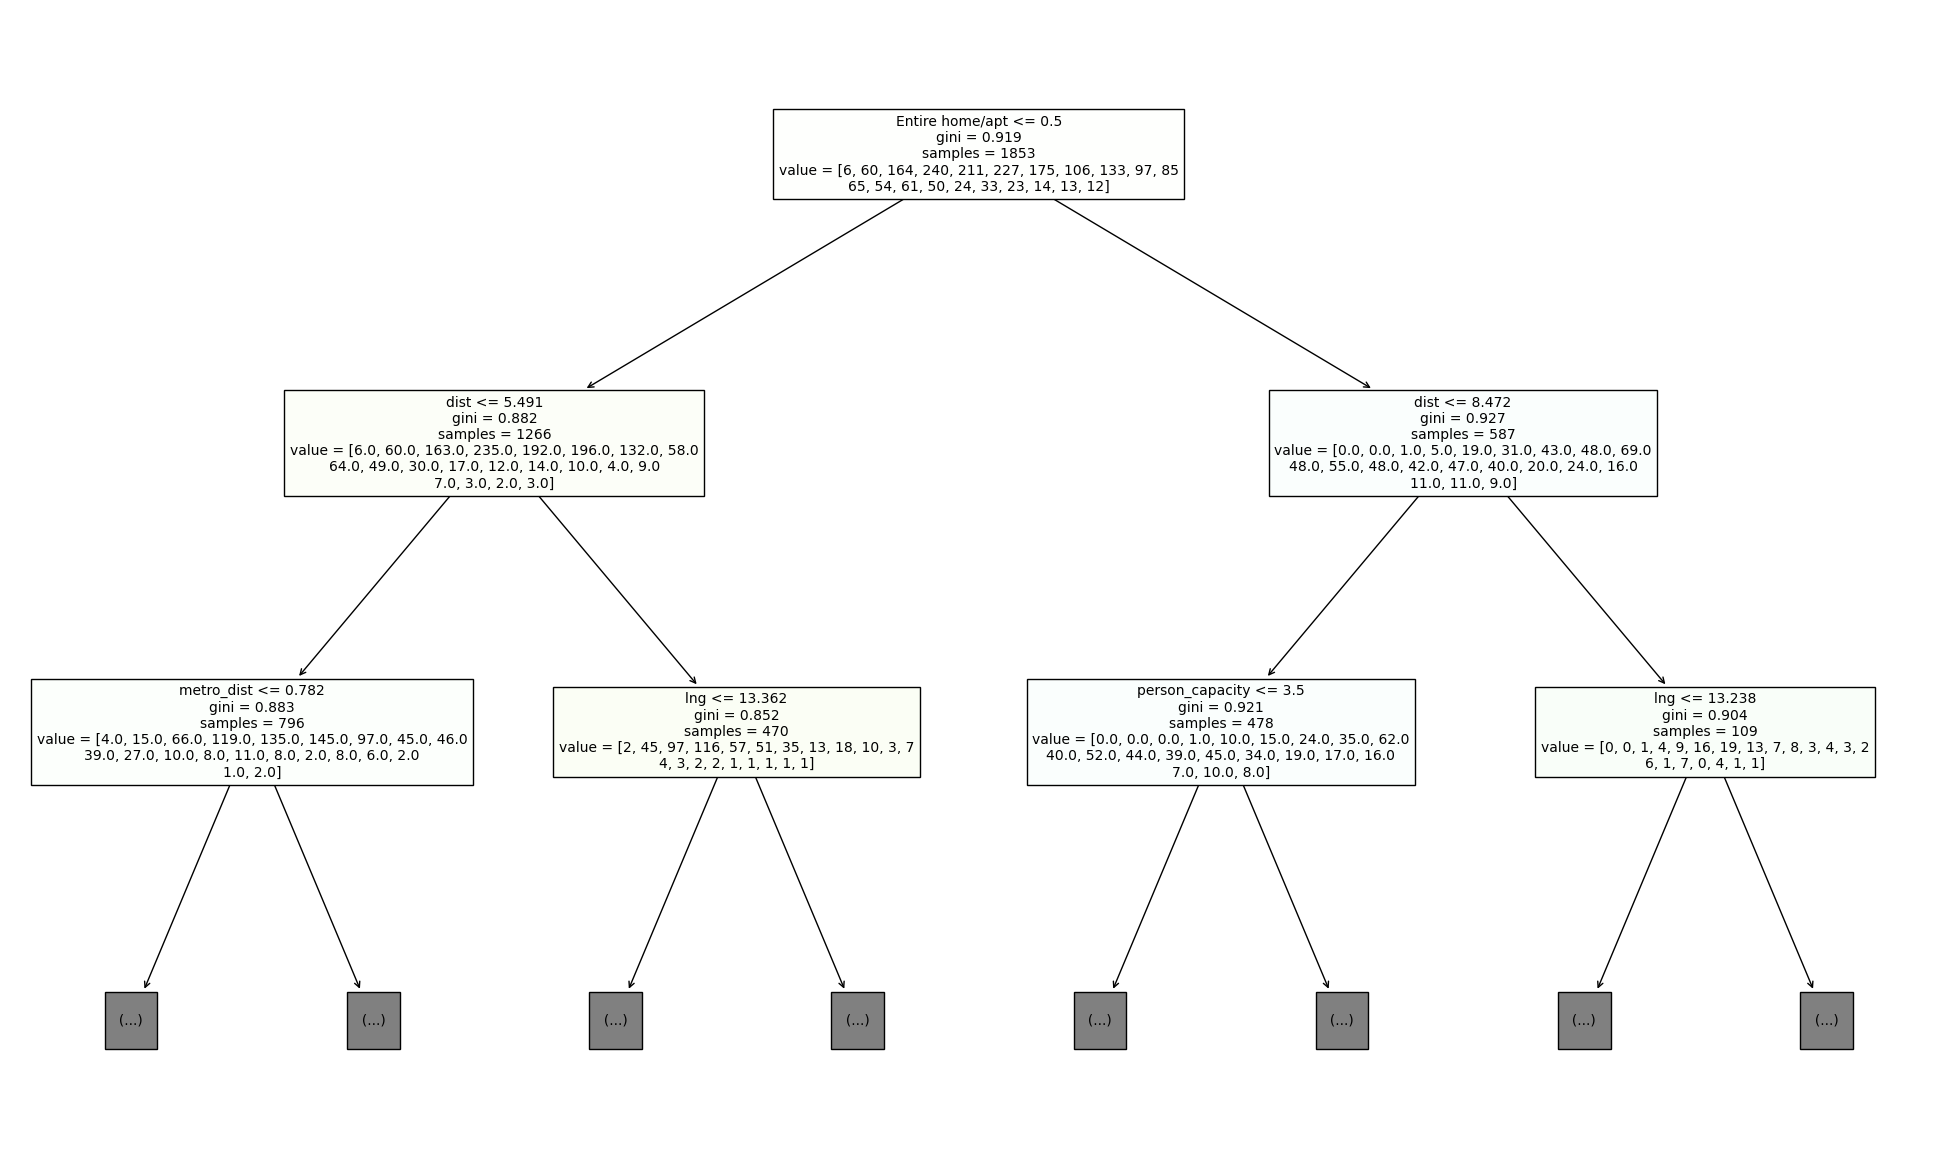

In [25]:
classifier = DecisionTreeClassifier(random_state=1, max_depth=22)
classifier = classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
score = classifier.score(x_test, y_test)

fig = plt.figure(figsize=(25,15))
tree.plot_tree(decision_tree=classifier, filled=True, max_depth=2, fontsize=10,feature_names=columns_of_interest)

decision_tree_evaluation = evaluate_model(y_test, y_pred)
#plot_metrics('Decision Tree Evaluation', decision_tree_evaluation)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df[columns_of_interest], df['realSum']//20 * 20, random_state=1, test_size=0.2)
y_train_pred_dt = classifier.predict(x_train)
y_test_pred_dt = classifier.predict(x_test)
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)

print(f'Decision Tree Train Accuracy: {train_accuracy_dt}')
print(f'Decision Tree Test Accuracy: {test_accuracy_dt}')

evaluate_model(y_test, y_test_pred_dt)
#plot_metrics('Decision Tree Evaluation', decision_tree_evaluation)

Decision Tree Train Accuracy: 0.9940636805180788
Decision Tree Test Accuracy: 0.5193965517241379
MAE: 33.44827586206897
MSE: 3808.6206896551726
RMSE: 61.7140234440696
R2: 0.5127087349123366


{'MAE': 33.44827586206897,
 'RMSE': 61.7140234440696,
 'MSE': 3808.6206896551726,
 'R2': 0.5127087349123366}

## Random Forest Classifier

In [27]:
x_train, x_test, y_train, y_test = train_test_split(df[columns_of_interest], df['realSum'] // 1, random_state=1)

rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

random_forest_evaluation = evaluate_model(y_test, y_pred)
#plot_metrics('Random Forest Evaluation', random_forest_evaluation)

Accuracy: 0.36379310344827587
Classification Report:
              precision    recall  f1-score   support

        64.0       0.00      0.00      0.00         0
        81.0       0.67      0.67      0.67         3
        83.0       0.00      0.00      0.00         1
        85.0       0.00      0.00      0.00         1
        86.0       1.00      1.00      1.00         1
        90.0       1.00      1.00      1.00         1
        91.0       0.00      0.00      0.00         0
        92.0       0.17      1.00      0.29         1
        93.0       0.00      0.00      0.00         1
        96.0       0.00      0.00      0.00         2
        99.0       0.00      0.00      0.00         3
       101.0       1.00      1.00      1.00         1
       102.0       0.33      1.00      0.50         1
       103.0       0.00      0.00      0.00         1
       104.0       0.25      0.14      0.18         7
       105.0       0.00      0.00      0.00         2
       107.0       0.00     

## Random Forest Regressor

In [28]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(df[columns_of_interest], df['realSum'], random_state=1)
rf_reg.fit(x_train, y_train)
y_pred = rf_reg.predict(x_test)
random_forest_reg_evaluation = evaluate_model(y_test, y_pred)
#plot_metrics('Random Forest Regression Evaluation', random_forest_reg_evaluation)

MAE: 34.04535351516538
MSE: 2386.9222703691967
RMSE: 48.85613851267
R2: 0.6953215942060849


In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=1), param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)


best_rf_model = grid_search.best_estimator_

In [39]:
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [30]:
# Decision Tree
cv_scores_dt = cross_val_score(classifier, df[columns_of_interest], df['target_quantiles'], cv=5)
print(f'Decision Tree Cross-Validation Scores: {cv_scores_dt}')
print(f'Decision Tree Average CV Score: {cv_scores_dt.mean()}')

# Random Forest
cv_scores_rf = cross_val_score(rf_model, df[columns_of_interest], df['target_quantiles'], cv=5)
print(f'Random Forest Cross-Validation Scores: {cv_scores_rf}')
print(f'Random Forest Average CV Score: {cv_scores_rf.mean()}')

# Best Random Forest
cv_scores_rf = cross_val_score(best_rf_model, df[columns_of_interest], df['target_quantiles'], cv=5)
print(f'Random Forest Cross-Validation Scores: {cv_scores_rf}')
print(f'Random Forest Average CV Score: {cv_scores_rf.mean()}')

Decision Tree Cross-Validation Scores: [0.4762931  0.58405172 0.59179266 0.57451404 0.68898488]
Decision Tree Average CV Score: 0.5831272808520146
Random Forest Cross-Validation Scores: [0.57974138 0.63362069 0.64362851 0.61339093 0.69330454]
Random Forest Average CV Score: 0.6327372086095181
Random Forest Cross-Validation Scores: [0.73044814 0.83680568 0.76864328 0.73326864 0.81221114]
Random Forest Average CV Score: 0.7762753754806105


In [31]:
print(best_rf_model.score(x_test, y_test))
y_pred = best_rf_model.predict(x_test)
best_rf_model_evaluation = evaluate_model(y_test, y_pred)
#plot_metrics('Best Random Forest Evaluation', best_rf_model_evaluation)

0.6970649624174163
MAE: 34.16227999139791
MSE: 2373.2643138814774
RMSE: 48.71616070547306
R2: 0.6970649624174163


## Decision Tree and Random Forest Evaluation

The Decision Tree has worse metrics than the Random Forest, that isn't surprising since Random Forest contains multiple Decision Trees.

The Mean Absolute Error of our best Random Forest Model is around 34.16

The Mean Squared Error is around 2373.26

The Root Mean Square Error is around 48.72

The R² score is around 0.6971


## Support Vector Regression/Model

In [32]:

x_train, x_test, y_train, y_test = train_test_split(df[columns_of_interest], df['realSum'] // 20 * 20, random_state=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[columns_of_interest])

# Initialize the SVM model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
# Perform cross-validation
cv_scores = cross_val_score(svr_model, X_scaled, df['realSum']//1, cv=5)  # 5-fold cross-validation

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {cv_scores.mean()}')
svr_model.fit(x_train, y_train)
score = svr_model.score(x_test, y_test)
print(score)

y_pred = svr_model.predict(x_test)

svr_evaluation = evaluate_model(y_test, y_pred)
#plot_metrics('SVM Evaluation', svr_evaluation)

Cross-Validation Scores: [0.49277858 0.54966161 0.47061167 0.449999   0.53354433]
Mean Cross-Validation Score: 0.49931903637647546
0.48260915803158955
MAE: 45.50273321471434
MSE: 4062.567656154041
RMSE: 63.738274656238076
R2: 0.48260915803158955


## Model comparison

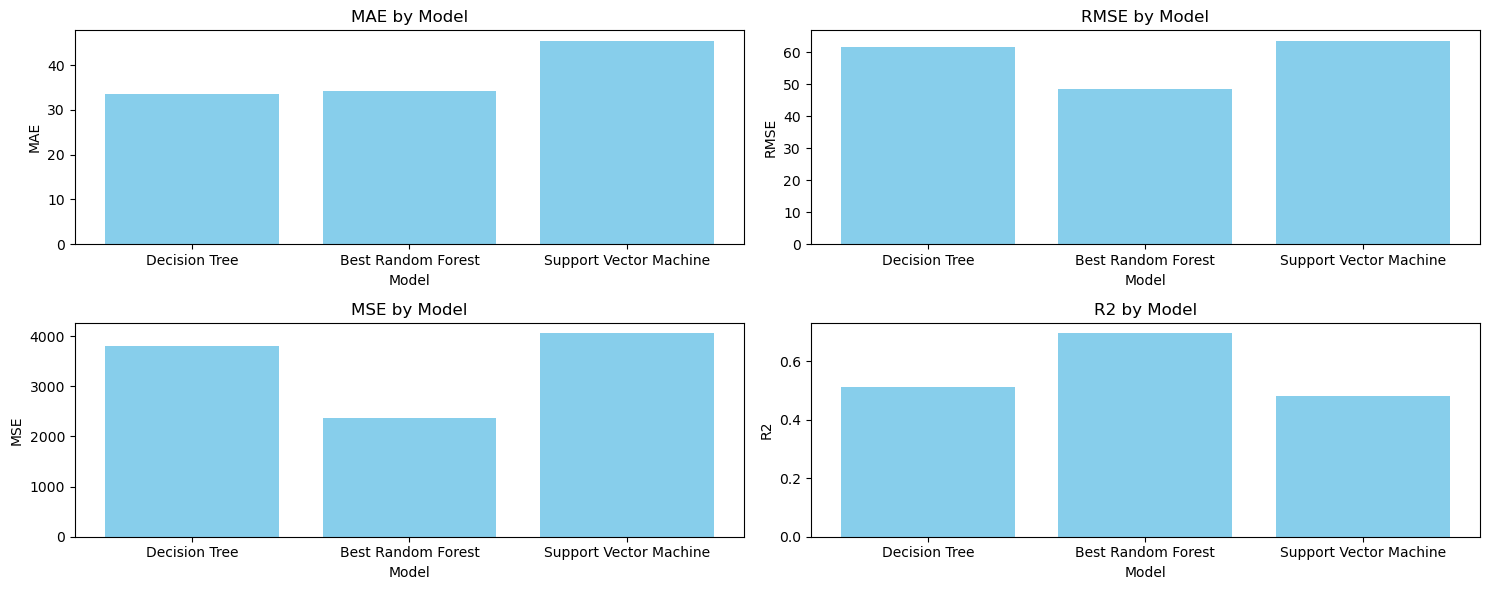

In [33]:
model_names = ['Decision Tree', 'Best Random Forest', 'Support Vector Machine']
metrics_dict_list = [decision_tree_evaluation, best_rf_model_evaluation, svr_evaluation]
metric_names = ['MAE', 'RMSE', 'MSE', 'R2']
plot_compare_metrics(model_names, metrics_dict_list, metric_names)

The best of all three models is the Random Forest model. It has the highest R2 score and the lowest RMSE, MSE, values. The Decision Tree model has the second best R2 score and the second-highest RMSE, MSE but the lowest MAE values, it seems to underpredict the price of an appartment. The Support Vector Machine model has the lowest R2 score and the highest RMSE, MSE, and MAE values.

# Prediction Function for apartment owner

This function should return a range of prices and the mean price of these models.

In [34]:
def predict_price(args: list) -> str:
    """
    Predicts and summarizes the price for weekdays and weekends based on input features using three models: RandomForestRegressor, a tuned RandomForestRegressor, and SVR.

    Args:
        args (list): A list of feature values excluding the binary feature indicating weekday (1) or weekend (0).

    Returns:
        str: A formatted string summarizing the predicted price range and recommended price for both weekdays and weekends.

    The function works as follows:
    1. It defines a helper function `helper` which appends a binary feature indicating weekday (1) or weekend (0) to the input features.
    2. The helper function makes predictions using three models: `rf_reg`, `best_rf_model`, and `svr_model`.
    3. It computes the range and mean of the predictions.
    4. For both weekday and weekend scenarios, the function:
       - Appends the binary feature (1 for weekday, 0 for weekend) to the input features.
       - Calls the helper function to get predictions and compute the range and mean prices.
       - Formats the results into a readable string.
    5. Returns a summary of the predicted price range and recommended price for both weekdays and weekends.

    Example:
        args = [feature1, feature2, feature3, ...]
        result = predict_price(args)
        print(result)
    
    Note:
        The models `rf_reg`, `best_rf_model`, and `svr_model` should be pre-trained and available in the global scope.
    """

    def helper(i):
        temp = args + [i]
        rf_pred = rf_reg.predict(np.array(temp).reshape((1, -1)))[0]
        best_rf_pred = best_rf_model.predict(np.array(temp).reshape((1, -1)))[0]
        svr_pred = svr_model.predict(np.array(temp).reshape((1, -1)))[0]
        range = np.ptp([rf_pred, best_rf_pred, svr_pred])
        mean_prices = np.mean([rf_pred, best_rf_pred, svr_pred])
        return rf_pred, best_rf_pred, svr_pred, mean_prices, range

    weekday = helper(1)
    weekend = helper(0)
    res = f'''The predicted price for weekdays is between {round(min(weekday[:4]), 2)} and {round(max(weekday[:4]), 2)}.\nWe would recommend a price of {round(weekday[-2], 2)}.\nThe predicted price for weekends is between {round(min(weekend[:4]), 2)} and {round(max(weekend[:4]), 2)}.\nWe would recommend a price of {round(weekend[-2], 2)}.\n'''
    return res


In [35]:
print(len(columns_of_interest))
print(columns_of_interest)

12
['multi', 'biz', 'host_is_superhost', 'person_capacity', 'bedrooms', 'dist', 'metro_dist', 'lng', 'lat', 'Entire home/apt', 'Private room', 'Weekday']


In [36]:
test_data = [0, 0, 0, 2, 2, 1, 0.4, 13.388860, 52.517037, 1, 0]
len(test_data)

11

In [37]:
print(predict_price(test_data))


The predicted price for weekdays is between 257.41 and 281.02.
We would recommend a price of 265.49.
The predicted price for weekends is between 263.18 and 301.93.
We would recommend a price of 283.89.

